In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
import torch
torch.cuda.device_count()  # print 1

1

In [5]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from glob import glob
# import wandb

import monai
from monai.losses import DiceCELoss, DiceFocalLoss, FocalLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    MapTransform,
    ScaleIntensityd,
    AddChanneld,
    SpatialPadd,
    CenterSpatialCropd,
    EnsureChannelFirstd,
    ConcatItemsd,
    AdjustContrastd, 
    Rand3DElasticd,
    HistogramNormalized,
    NormalizeIntensityd

)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR, UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)
from monai import data


from monai.utils import first, set_determinism
from sklearn.model_selection import train_test_split

# from unest_network.unest import UNesT

import torch

print_config()

MONAI version: 1.2.0
Numpy version: 1.25.2
Pytorch version: 2.0.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/ikboljonsobirov/.conda/envs/sega/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.21.0
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.2
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.0.3
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest

In [3]:
# set_determinism(seed=1024)
# wandb.init(project="hecktor2022-Transformers", name="3DSwinUNesT_111_176_PLS_random_pre-normalization")

In [4]:
set_determinism(seed=1024)

ct_path = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/predictions_crop/1_1_1_s176v2/ct'
pt_path = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/predictions_crop/1_1_1_s176v2/pt'
gtvt_path = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/predictions_crop/1_1_1_s176v2/gtvt'

ct = sorted(glob(os.path.join(ct_path, "*ct*.nii.gz")))
pt = sorted(glob(os.path.join(pt_path, "*pt*.nii.gz")))
gtvt = sorted(glob(os.path.join(gtvt_path, "*gtvt*.nii.gz")))

print(len(ct))

ct_train, ct_test, pt_train, pt_test, seg_train, seg_test = train_test_split(ct, pt,gtvt, test_size=0.15, random_state=1235)

train_files = [{"ct": ct_in, "pt": pt_in, "seg": gtvt_in} for ct_in, pt_in, gtvt_in in zip(ct_train, pt_train,seg_train)]
test_files = [{"ct": ct_in, "pt": pt_in, "seg": gtvt_in} for ct_in, pt_in, gtvt_in in zip(ct_test, pt_test, seg_test)]

523


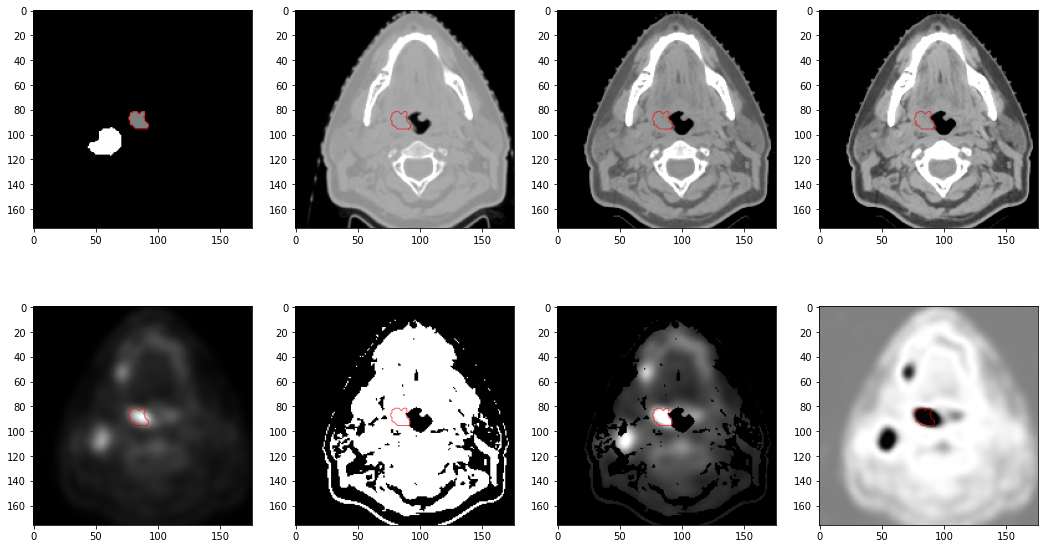

In [5]:
from skimage import measure

gt = monai.transforms.LoadImage(ensure_channel_first=True)('/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/predictions_crop/1_1_1_s176v2/gtvt/CHUM-008_gtvt_trans.nii.gz')
plt.figure("image", (18, 10))
gt = monai.transforms.Orientation(axcodes='PLS')(gt[0])
plt.subplot(2, 4, 1)
plt.imshow(gt[0,:,:,75], cmap='gray')
contours = measure.find_contours(gt[0,:,:,75], 0.5)[0]
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

ct = monai.transforms.LoadImage(ensure_channel_first=True)('/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/predictions_crop/1_1_1_s176v2/ct/CHUM-008_ct_trans.nii.gz')
ct = monai.transforms.Orientation(axcodes='PLS')(ct[0])
ct = torch.clip(ct, min=-1000, max=600)
plt.subplot(2, 4, 2)
plt.imshow(ct[0,:,:,75], cmap='gray')
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

ct = monai.transforms.LoadImage(ensure_channel_first=True)('/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/predictions_crop/1_1_1_s176v2/ct/CHUM-008_ct_trans.nii.gz')
ct = monai.transforms.Orientation(axcodes='PLS')(ct[0])
ct = torch.clip(ct, min=-300, max=300)
plt.subplot(2, 4, 3)
plt.imshow(ct[0,:,:,75], cmap='gray')
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

ct = monai.transforms.LoadImage(ensure_channel_first=True)('/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/predictions_crop/1_1_1_s176v2/ct/CHUM-008_ct_trans.nii.gz')
ct = monai.transforms.Orientation(axcodes='PLS')(ct[0])
ct = torch.clip(ct, min=-200, max=200)
plt.subplot(2, 4, 4)
plt.imshow(ct[0,:,:,75], cmap='gray')
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

pt = monai.transforms.LoadImage(ensure_channel_first=True)('/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/predictions_crop/1_1_1_s176v2/pt/CHUM-008_pt_trans.nii.gz')
pt = monai.transforms.Orientation(axcodes='PLS')(pt[0])
plt.subplot(2, 4, 5)
plt.imshow(pt[0,:,:,75], cmap='gray')
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

fm = ct>0
pt = np.clip(pt, pt.min(), 5)
PTfm = pt*fm

plt.subplot(2, 4, 6)
plt.imshow(fm[0,:,:,75], cmap='gray')
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

plt.subplot(2, 4, 7)
plt.imshow(PTfm[0,:,:,75], cmap='gray')
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

plt.subplot(2, 4, 8)
pt = np.sin(pt)
pt = monai.transforms.NormalizeIntensity()(pt)
plt.imshow(pt[0,:,:,75], cmap='gray')
plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

In [4]:
class ClipCT(MapTransform):
    """
    Convert labels to multi channels based on hecktor classes:
    label 1 is the tumor
    label 2 is the lymph node

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            if key == "ct":
                d[key] = torch.clip(d[key], min=-200, max=200)
            # elif key == "pt":
            #     d[key] = torch.clip(d[key], d[key].min(), 5)
        return d
class MulPTFM(MapTransform):
    """
    Mult PT and FM 

    """

    def __call__(self, data):
        d = dict(data)

        fm = d["ct"] > 0
        d["pt"] = d["pt"] * fm
        return d
class SelectClass(MapTransform):
    """
    Select the class for which you want to fine tune the model 

    """
    # def __init__(self, keys, cls=1):
    #     super(self).__init__(keys)
    #     self.cls = cls

    def __call__(self, data):
        d = dict(data)
        d["seg"][d["seg"] == 1] = 0
        # d["seg"][d["seg"] == 2] = 1
        
        return d

In [7]:
num_samples = 4

train_transforms = Compose(
    [
        LoadImaged(keys=["ct", "pt", "seg"], ensure_channel_first = True),
        SpatialPadd(keys=["ct", "pt", "seg"], spatial_size=(176,176,176), method='end'),
        Orientationd(keys=["ct", "pt", "seg"], axcodes="PLS"),
        NormalizeIntensityd(keys=["pt"]),
        ClipCT(keys=["ct"]),
        ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
        #MulPTFM(keys=["ct","pt"]),
        ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
        #NormalizeIntensityd(keys=["ctpt"], channel_wise=True),
        RandCropByPosNegLabeld(
            keys=["ctpt", "seg"],
            label_key="seg",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="ctpt",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["ctpt", "seg"],
            spatial_axis=[0],
            prob=0.20,
        ),
        RandFlipd(
            keys=["ctpt", "seg"],
            spatial_axis=[1],
            prob=0.20,
        ),
        RandFlipd(
            keys=["ctpt", "seg"],
            spatial_axis=[2],
            prob=0.20,
        ),
        RandRotate90d(
            keys=["ctpt", "seg"],
            prob=0.20,
            max_k=3,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["ct", "pt", "seg"], ensure_channel_first = True),
        SpatialPadd(keys=["ct", "pt", "seg"], spatial_size=(176,176,176), method='end'),
        Orientationd(keys=["ct", "pt", "seg"], axcodes="PLS"),
        NormalizeIntensityd(keys=["pt"]),
        ClipCT(keys=["ct"]),
        ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
        #MulPTFM(keys=["ct","pt"]),
        ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
    ]
)

val_ds = CacheDataset(
    data=test_files, transform=train_transforms, cache_num=6, num_workers=4
)

Loading dataset: 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


image shape: torch.Size([2, 96, 96, 96]), label shape: torch.Size([1, 96, 96, 96])


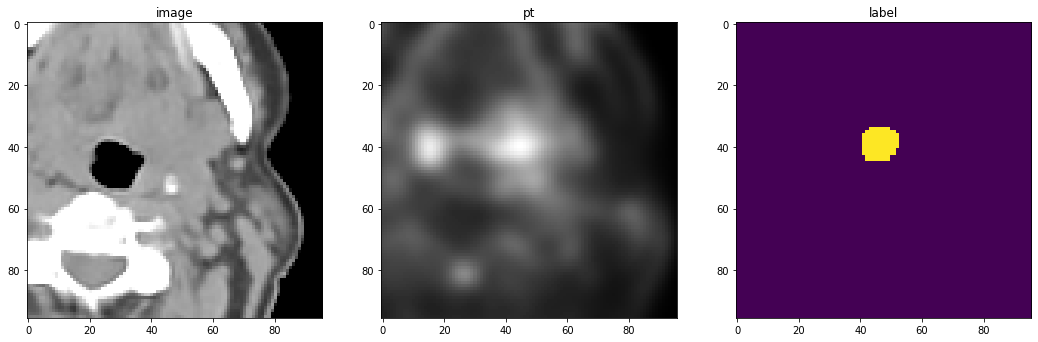

In [19]:
case = val_ds[0][0]
img = case["ctpt"]
pt = case["ctpt"]
label = case["seg"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img[1, :, :, 40].detach().cpu(), cmap="gray")
plt.subplot(1, 3, 2)
plt.title("pt")
plt.imshow(pt[0, :, :, 40].detach().cpu(), cmap="gray")
plt.subplot(1, 3, 3)
plt.title("label")
plt.imshow(label[0, :, :, 40].detach().cpu())
plt.show()

In [20]:
 # create a training data loader
train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

train_loader = DataLoader(
    train_ds,
    batch_size=3,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available(),
    )


# create a validation data loader
val_ds = monai.data.Dataset(data=test_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=2, num_workers=4, shuffle= False)

In [8]:
cd ..

/home/ikboljonsobirov/hecktor/fusion_vit/fusion_vit_project


In [23]:
import json
from src.data.augmentations import *
from monai import transforms
from monai.networks.nets import SwinUNETR, UNet, SegResNet


In [12]:
def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val

In [13]:
def get_loader(batch_size, sw_batch_size, data_dir, json_list, fold):
    data_dir = data_dir
    datalist_json = json_list

    train_files, validation_files = datafold_read(datalist=datalist_json, basedir=data_dir, fold=fold)
    train_transform = transforms.Compose(
        [
            LoadImagedMonai(keys=["image","image2", "label"], ensure_channel_first = True),
            transforms.SpatialPadd(keys=["image", "label"], spatial_size=(roi[0], roi[1], roi[2]), method='end'),
            transforms.RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=roi,
                pos=1,
                neg=1,
                num_samples=1,
                image_key="image",
                image_threshold=0,
            ),
            # transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            # # transforms.ScaleIntensityRanged(keys=["image"], a_min=-1024, a_max=1024, b_min=0.0, b_max=1.0, clip=True),
            # # ClipCT(keys=["image"]),

            # transforms.RandFlipd(
            #     keys=["image", "label"],
            #     spatial_axis=[0],
            #     prob=0.20,
            # ),
            # transforms.RandFlipd(
            #     keys=["image", "label"],
            #     spatial_axis=[1],
            #     prob=0.20,
            # ),
            # transforms.RandFlipd(
            #     keys=["image", "label"],
            #     spatial_axis=[2],
            #     prob=0.20,
            # ),
            # transforms.RandRotate90d(
            #     keys=["image", "label"],
            #     prob=0.20,
            #     max_k=3,
            # ),
            # transforms.RandShiftIntensityd(
            #     keys=["image"],
            #     offsets=0.10,
            #     prob=0.50,
            # ),
            # transforms.RandZoomd(   #added new
            #     keys=["image", "label"],
            #     prob = 0.5,
            #     min_zoom = 0.85,
            #     max_zoom = 1.15,
            #     mode = ['area', 'nearest'],
            # ),
            
    
            # transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=0.5),
            # transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=0.5),
        ]
    )

    val_transform = transforms.Compose(
        [
            LoadImagedMonai(keys=["image", "image2", "label"], ensure_channel_first = True),
            # transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
            # # transforms.CropForegroundd(keys=["image", "label"], source_key="image"),
            # # transforms.ScaleIntensityRanged(keys=["image"], a_min=-1024, a_max=1024, b_min=0.0, b_max=1.0, clip=True),
            # transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ]
    )
    train_ds = data.Dataset(data=train_files, transform=train_transform)


    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
    )
    val_ds = data.Dataset(data=validation_files, transform=val_transform)

    val_loader = data.DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
    )

    return train_loader, val_loader, train_ds, val_ds

In [16]:
root_dir = ""
roi = (96,96,96)
data_dir = '/share/nvmedata/ikboljonsobirov/fusion_vit/hecktor2022_cropped/'
# data_dir_orig = '/Users/ikboljon.sobirov/Documents/sega23/SegAorta/'
datalist_json = '/home/ikboljonsobirov/hecktor/fusion_vit/fusion_vit_project/files/train_json.json'
batch_size = 1
sw_batch_size = 1
fold = 0 # 0,1,2,3,4
# roi = (64,64,64)
infer_overlap = 0.5
chkpt_path = '/home/ikboljonsobirov/hecktor/fusion_vit/fusion_vit_project/logs/train/runs/2023-09-29_16-25-56/checkpoints/epoch_063.ckpt'

In [17]:
train_loader, val_loader, train_ds, val_ds = get_loader(batch_size, sw_batch_size, data_dir, datalist_json, fold)

In [18]:
a = next(iter(train_loader))

In [22]:
a['label'].shape, a['image'].shape

(torch.Size([1, 1, 96, 96, 96]), torch.Size([1, 2, 96, 96, 96]))

In [24]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = UNETR(
#     in_channels=2,
#     out_channels=3,
#     img_size=(96, 96, 96),
#     feature_size=16,
#     hidden_size=768,
#     mlp_dim=3072,
#     num_heads=12,
#     pos_embed="perceptron",
#     norm_name="instance",
#     res_block=True,
#     dropout_rate=0.0,
# ).to(device)

model = SegResNet(in_channels=2, 
                  out_channels=3, 
                  init_filters=16).to(device)

# model = UTNetV2(in_chan=2, num_classes=3).to(device)

In [22]:
# try:
#         model_dict = torch.load('/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/Pretrain/runs/logs_ctfinal_model.pth')
#         state_dict = model_dict['state_dict']

#         # fix potential differences in state dict keys from pre-training to fine-tuning
#         if 'UNesT.' in list(state_dict.keys())[0]:
#             print("Tag 'UNesT.' found in state dict - fixing!")
#             for key in list(state_dict.keys()):
#                 state_dict[key.replace('UNesT.', '')] = state_dict.pop(key)

#         ### Due to CT-PET we are copying the weights in the second dimension because of 2 channels
#         x_proj_weight = state_dict['nestViT.patch_embed.proj.weight']
#         state_dict['nestViT.patch_embed.proj.weight'] = x_proj_weight.repeat(1,2,1,1,1)

#         encoder_proj_weight = state_dict['encoder1.layer.conv1.conv.weight']
#         state_dict['encoder1.layer.conv1.conv.weight'] = encoder_proj_weight.repeat(1,2,1,1,1)

#         encoder_conv3_proj_weight = state_dict['encoder1.layer.conv3.conv.weight']
#         state_dict['encoder1.layer.conv3.conv.weight'] = encoder_conv3_proj_weight.repeat(1,2,1,1,1)
    
        
#         # We now load model weights, setting param `strict` to False, i.e.:
#         # this load the encoder weights (Swin-ViT, SSL pre-trained), but leaves
#         # the decoder weights untouched (CNN UNet decoder).
#         model.load_state_dict(state_dict, strict=False)
#         print('Using pretrained UNesT backbone weights !')
# except ValueError:
#         raise ValueError('Self-supervised pre-trained weights not available for the model.')

# model_dict = torch.load('/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/data/best_metric_luck_UNETr.pth')

# model_dict['out.conv.conv.weight'] = torch.randn((2,16,1,1,1))
# model_dict['out.conv.conv.bias'] = torch.randn((2))
# model.load_state_dict(model_dict, strict=False)

# root_dir = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/data/'
# model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_luck_UNETr.pth")), strict=False)

In [23]:
# for p in model.parameters():
#     p.requires_grad = False

# model.vit.prompt_vectors.requires_grad = True
# model.out.conv.conv.weight.requires_grad = True
# model.out.conv.conv.bias.requires_grad = True
# model.decoder2.requires_grad=True

In [25]:
torch.backends.cudnn.benchmark = True
def poly_lr(epoch, max_epochs, initial_lr, exponent=0.9):
    return initial_lr * (1 - epoch / max_epochs)**exponent

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [28]:
model_dir = '/home/ikboljonsobirov/hecktor/fusion_vit/fusion_vit_project/files/'

def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice_metric_batch(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps)" % (global_step, 10.0)
            )
        mean_dice_val = dice_metric.aggregate().item()
        metric_batch_val = dice_metric_batch.aggregate()

        metric_tumor = metric_batch_val[0].item()
        metric_lymph = metric_batch_val[1].item()

        dice_metric.reset()
        dice_metric_batch.reset()
    return mean_dice_val, metric_tumor, metric_lymph


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)"
            % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val, metric_tumor, metric_lymph = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            metric_values_tumor.append(metric_tumor)
            metric_values_lymph.append(metric_lymph)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(model_dir, "best_metric.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {} Current Avg. tumor Dice: {} Current Avg. lymph Dice: {}".format(
                        dice_val_best, dice_val, metric_tumor, metric_lymph
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {} Current Avg. tumor Dice: {} Current Avg. lymph Dice: {}".format(
                        dice_val_best, dice_val,  metric_tumor, metric_lymph
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 18000
eval_num = 100

post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)

dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")

epoch = 0
max_num_epochs = 530

global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
metric_values_tumor = []
metric_values_lymph = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
    # wandb.log({'learning_rate': optimizer.param_groups[0]['lr']})
    # wandb.log({'Best Dice': dice_val_best})
    epoch += 1
    #optimizer.param_groups[0]['lr'] = poly_lr(epoch, max_num_epochs, 0.005676 , 0.9)
model.load_state_dict(torch.load(os.path.join(model_dir, "best_metric.pth")))

Training (103 / 18000 Steps) (loss=1.52230):  25%|██▍       | 103/419 [00:59<26:50,  5.10s/it]

Model Was Saved ! Current Best Avg. Dice: 6.806559395045042e-05 Current Avg. Dice: 6.806559395045042e-05 Current Avg. tumor Dice: 0.00014293774438556284 Current Avg. lymph Dice: 0.0


Training (203 / 18000 Steps) (loss=1.39032):  48%|████▊     | 203/419 [01:56<18:30,  5.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 6.806559395045042e-05 Current Avg. Dice: 0.0 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.0


Training (303 / 18000 Steps) (loss=1.30835):  72%|███████▏  | 303/419 [02:53<09:58,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 6.806559395045042e-05 Current Avg. Dice: 0.0 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.0


Training (403 / 18000 Steps) (loss=1.19224):  96%|█████████▌| 403/419 [03:50<01:22,  5.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 6.806559395045042e-05 Current Avg. Dice: 0.0 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.0


Training (503 / 18000 Steps) (loss=1.12394):  20%|██        | 84/419 [00:56<32:01,  5.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 6.806559395045042e-05 Current Avg. Dice: 0.0 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.0


Training (603 / 18000 Steps) (loss=1.05889):  44%|████▍     | 184/419 [01:52<20:10,  5.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 6.806559395045042e-05 Current Avg. Dice: 0.0 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.0


Training (703 / 18000 Steps) (loss=1.00304):  68%|██████▊   | 284/419 [02:49<11:35,  5.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 6.806559395045042e-05 Current Avg. Dice: 0.0 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.0


Training (803 / 18000 Steps) (loss=0.96168):  92%|█████████▏| 384/419 [03:45<03:00,  5.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 6.806559395045042e-05 Current Avg. Dice: 0.0 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.0


Training (903 / 18000 Steps) (loss=0.93021):  16%|█▌        | 65/419 [00:54<30:14,  5.13s/it]

Model Was Not Saved ! Current Best Avg. Dice: 6.806559395045042e-05 Current Avg. Dice: 0.0 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.0


Training (1003 / 18000 Steps) (loss=0.90537):  39%|███▉      | 165/419 [01:51<21:50,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 6.806559395045042e-05 Current Avg. Dice: 0.0 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.0


Training (1103 / 18000 Steps) (loss=0.85812):  63%|██████▎   | 265/419 [02:47<13:14,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 6.806559395045042e-05 Current Avg. Dice: 0.0 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.0


Training (1203 / 18000 Steps) (loss=0.84042):  87%|████████▋ | 365/419 [03:43<04:37,  5.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 6.806559395045042e-05 Current Avg. Dice: 0.0 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.0


Training (1303 / 18000 Steps) (loss=0.80493):  11%|█         | 46/419 [00:53<35:45,  5.75s/it]

Model Was Saved ! Current Best Avg. Dice: 0.010122661478817463 Current Avg. Dice: 0.010122661478817463 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.023187126964330673


Training (1403 / 18000 Steps) (loss=0.80676):  35%|███▍      | 146/419 [01:49<23:24,  5.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.010122661478817463 Current Avg. Dice: 0.007243164349347353 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.016926947981119156


Training (1503 / 18000 Steps) (loss=0.77800):  59%|█████▊    | 246/419 [02:45<14:51,  5.16s/it]

Model Was Saved ! Current Best Avg. Dice: 0.02754812315106392 Current Avg. Dice: 0.02754812315106392 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.06329035013914108


Training (1603 / 18000 Steps) (loss=0.76956):  83%|████████▎ | 346/419 [03:42<06:17,  5.18s/it]

Model Was Saved ! Current Best Avg. Dice: 0.053186871111392975 Current Avg. Dice: 0.053186871111392975 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.11696050316095352


Training (1703 / 18000 Steps) (loss=0.75588):   6%|▋         | 27/419 [00:51<34:00,  5.21s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.053186871111392975 Current Avg. Dice: 0.017234085127711296 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.03899073228240013


Training (1803 / 18000 Steps) (loss=0.74554):  30%|███       | 127/419 [01:48<25:04,  5.15s/it]

Model Was Saved ! Current Best Avg. Dice: 0.062108803540468216 Current Avg. Dice: 0.062108803540468216 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.13717544078826904


Training (1903 / 18000 Steps) (loss=0.73838):  54%|█████▍    | 227/419 [02:44<16:32,  5.17s/it]

Model Was Saved ! Current Best Avg. Dice: 0.09156015515327454 Current Avg. Dice: 0.09156015515327454 Current Avg. tumor Dice: 0.03662535175681114 Current Avg. lymph Dice: 0.16328886151313782


Training (2003 / 18000 Steps) (loss=0.78748):  78%|███████▊  | 327/419 [03:41<07:55,  5.17s/it]

Model Was Saved ! Current Best Avg. Dice: 0.17694367468357086 Current Avg. Dice: 0.17694367468357086 Current Avg. tumor Dice: 0.17299549281597137 Current Avg. lymph Dice: 0.18736116588115692


Training (2103 / 18000 Steps) (loss=0.65918):   2%|▏         | 8/419 [00:50<51:09,  7.47s/it]  

Model Was Saved ! Current Best Avg. Dice: 0.24894721806049347 Current Avg. Dice: 0.24894721806049347 Current Avg. tumor Dice: 0.2947435975074768 Current Avg. lymph Dice: 0.18911480903625488


Training (2203 / 18000 Steps) (loss=0.63462):  26%|██▌       | 108/419 [01:46<26:48,  5.17s/it]

Model Was Saved ! Current Best Avg. Dice: 0.29750359058380127 Current Avg. Dice: 0.29750359058380127 Current Avg. tumor Dice: 0.40190234780311584 Current Avg. lymph Dice: 0.14988194406032562


Training (2303 / 18000 Steps) (loss=0.68030):  50%|████▉     | 208/419 [02:42<18:02,  5.13s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.29750359058380127 Current Avg. Dice: 0.17725230753421783 Current Avg. tumor Dice: 0.2268364578485489 Current Avg. lymph Dice: 0.124144047498703


Training (2403 / 18000 Steps) (loss=0.67455):  74%|███████▎  | 308/419 [03:38<09:30,  5.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.29750359058380127 Current Avg. Dice: 0.20550379157066345 Current Avg. tumor Dice: 0.26503828167915344 Current Avg. lymph Dice: 0.1262483447790146


Training (2503 / 18000 Steps) (loss=0.58295):  97%|█████████▋| 408/419 [04:35<00:56,  5.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.29750359058380127 Current Avg. Dice: 0.29220032691955566 Current Avg. tumor Dice: 0.3864515721797943 Current Avg. lymph Dice: 0.1562926471233368


Training (2603 / 18000 Steps) (loss=0.72826):  21%|██        | 89/419 [00:57<28:15,  5.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.29750359058380127 Current Avg. Dice: 0.2800115942955017 Current Avg. tumor Dice: 0.4371938407421112 Current Avg. lymph Dice: 0.0661526545882225


Training (2703 / 18000 Steps) (loss=0.69481):  45%|████▌     | 189/419 [01:54<19:46,  5.16s/it]

Model Was Saved ! Current Best Avg. Dice: 0.2988876402378082 Current Avg. Dice: 0.2988876402378082 Current Avg. tumor Dice: 0.4261248707771301 Current Avg. lymph Dice: 0.11116112023591995


Training (2803 / 18000 Steps) (loss=0.69181):  69%|██████▉   | 289/419 [02:51<11:10,  5.16s/it]

Model Was Saved ! Current Best Avg. Dice: 0.3178353011608124 Current Avg. Dice: 0.3178353011608124 Current Avg. tumor Dice: 0.3534272015094757 Current Avg. lymph Dice: 0.2513788640499115


Training (2903 / 18000 Steps) (loss=0.61867):  93%|█████████▎| 389/419 [03:48<02:35,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3178353011608124 Current Avg. Dice: 0.2715831995010376 Current Avg. tumor Dice: 0.36479151248931885 Current Avg. lymph Dice: 0.15109975636005402


Training (3003 / 18000 Steps) (loss=0.51566):  17%|█▋        | 70/419 [00:55<33:27,  5.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3178353011608124 Current Avg. Dice: 0.2641277015209198 Current Avg. tumor Dice: 0.383109450340271 Current Avg. lymph Dice: 0.09970825165510178


Training (3103 / 18000 Steps) (loss=0.58320):  41%|████      | 170/419 [01:52<21:28,  5.18s/it]

Model Was Saved ! Current Best Avg. Dice: 0.3435227870941162 Current Avg. Dice: 0.3435227870941162 Current Avg. tumor Dice: 0.44497281312942505 Current Avg. lymph Dice: 0.19735883176326752


Training (3203 / 18000 Steps) (loss=0.68318):  64%|██████▍   | 270/419 [02:48<12:50,  5.17s/it]

Model Was Saved ! Current Best Avg. Dice: 0.36076289415359497 Current Avg. Dice: 0.36076289415359497 Current Avg. tumor Dice: 0.40272292494773865 Current Avg. lymph Dice: 0.2752557098865509


Training (3303 / 18000 Steps) (loss=0.55644):  88%|████████▊ | 370/419 [03:44<04:13,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.36076289415359497 Current Avg. Dice: 0.34513142704963684 Current Avg. tumor Dice: 0.3768966794013977 Current Avg. lymph Dice: 0.28000780940055847


Training (3403 / 18000 Steps) (loss=0.53992):  12%|█▏        | 51/419 [00:53<31:32,  5.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.36076289415359497 Current Avg. Dice: 0.2819504141807556 Current Avg. tumor Dice: 0.2961874008178711 Current Avg. lymph Dice: 0.25936564803123474


Training (3503 / 18000 Steps) (loss=0.71689):  36%|███▌      | 151/419 [01:50<23:02,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.36076289415359497 Current Avg. Dice: 0.3408403694629669 Current Avg. tumor Dice: 0.43741434812545776 Current Avg. lymph Dice: 0.19208189845085144


Training (3603 / 18000 Steps) (loss=0.63864):  60%|█████▉    | 251/419 [02:46<14:26,  5.16s/it]

Model Was Saved ! Current Best Avg. Dice: 0.396934449672699 Current Avg. Dice: 0.396934449672699 Current Avg. tumor Dice: 0.4403288662433624 Current Avg. lymph Dice: 0.3194561302661896


Training (3703 / 18000 Steps) (loss=0.49568):  84%|████████▍ | 351/419 [03:42<05:49,  5.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.396934449672699 Current Avg. Dice: 0.3863410949707031 Current Avg. tumor Dice: 0.43577584624290466 Current Avg. lymph Dice: 0.3165062367916107


Training (3803 / 18000 Steps) (loss=0.55373):   8%|▊         | 32/419 [00:52<37:11,  5.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.396934449672699 Current Avg. Dice: 0.2879837453365326 Current Avg. tumor Dice: 0.2615276873111725 Current Avg. lymph Dice: 0.3212638795375824


Training (3903 / 18000 Steps) (loss=0.70532):  32%|███▏      | 132/419 [01:48<24:36,  5.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.396934449672699 Current Avg. Dice: 0.19298869371414185 Current Avg. tumor Dice: 0.24672828614711761 Current Avg. lymph Dice: 0.13454362750053406


Training (4003 / 18000 Steps) (loss=0.65836):  55%|█████▌    | 232/419 [02:44<16:07,  5.17s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4086441099643707 Current Avg. Dice: 0.4086441099643707 Current Avg. tumor Dice: 0.4602416753768921 Current Avg. lymph Dice: 0.3511064052581787


Training (4103 / 18000 Steps) (loss=0.67442):  79%|███████▉  | 332/419 [03:41<07:29,  5.17s/it]

Model Was Saved ! Current Best Avg. Dice: 0.46660345792770386 Current Avg. Dice: 0.46660345792770386 Current Avg. tumor Dice: 0.4994926452636719 Current Avg. lymph Dice: 0.4204682409763336


Training (4203 / 18000 Steps) (loss=0.39198):   3%|▎         | 13/419 [00:50<38:48,  5.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.46660345792770386 Current Avg. Dice: 0.42573365569114685 Current Avg. tumor Dice: 0.4796398878097534 Current Avg. lymph Dice: 0.3590862452983856


Training (4303 / 18000 Steps) (loss=0.70120):  27%|██▋       | 113/419 [01:47<26:17,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.46660345792770386 Current Avg. Dice: 0.4197397828102112 Current Avg. tumor Dice: 0.4411798119544983 Current Avg. lymph Dice: 0.39805153012275696


Training (4403 / 18000 Steps) (loss=0.45772):  51%|█████     | 213/419 [02:43<17:39,  5.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.46660345792770386 Current Avg. Dice: 0.4445536434650421 Current Avg. tumor Dice: 0.471009224653244 Current Avg. lymph Dice: 0.4089396297931671


Training (4503 / 18000 Steps) (loss=0.48299):  75%|███████▍  | 313/419 [03:39<09:07,  5.16s/it]

Model Was Saved ! Current Best Avg. Dice: 0.48384007811546326 Current Avg. Dice: 0.48384007811546326 Current Avg. tumor Dice: 0.5265927910804749 Current Avg. lymph Dice: 0.4247285723686218


Training (4603 / 18000 Steps) (loss=0.67213):  99%|█████████▊| 413/419 [04:35<00:30,  5.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.48384007811546326 Current Avg. Dice: 0.4556027054786682 Current Avg. tumor Dice: 0.47979533672332764 Current Avg. lymph Dice: 0.41670307517051697


Training (4703 / 18000 Steps) (loss=0.56100):  22%|██▏       | 94/419 [00:57<31:05,  5.74s/it]

Model Was Saved ! Current Best Avg. Dice: 0.49045053124427795 Current Avg. Dice: 0.49045053124427795 Current Avg. tumor Dice: 0.5352241396903992 Current Avg. lymph Dice: 0.4348835349082947


Training (4803 / 18000 Steps) (loss=0.29137):  46%|████▋     | 194/419 [01:54<19:23,  5.17s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4976155459880829 Current Avg. Dice: 0.4976155459880829 Current Avg. tumor Dice: 0.5571577548980713 Current Avg. lymph Dice: 0.4269062578678131


Training (4903 / 18000 Steps) (loss=0.67866):  70%|███████   | 294/419 [02:50<10:48,  5.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4976155459880829 Current Avg. Dice: 0.4906780421733856 Current Avg. tumor Dice: 0.527908205986023 Current Avg. lymph Dice: 0.4448918104171753


Training (5003 / 18000 Steps) (loss=0.66932):  94%|█████████▍| 394/419 [03:47<02:08,  5.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4976155459880829 Current Avg. Dice: 0.46641525626182556 Current Avg. tumor Dice: 0.48420703411102295 Current Avg. lymph Dice: 0.4241151809692383


Training (5103 / 18000 Steps) (loss=0.47723):  18%|█▊        | 75/419 [00:55<29:31,  5.15s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5116950869560242 Current Avg. Dice: 0.5116950869560242 Current Avg. tumor Dice: 0.5504629611968994 Current Avg. lymph Dice: 0.46407991647720337


Training (5203 / 18000 Steps) (loss=0.48360):  42%|████▏     | 175/419 [01:52<21:00,  5.16s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5336824655532837 Current Avg. Dice: 0.5336824655532837 Current Avg. tumor Dice: 0.5860104560852051 Current Avg. lymph Dice: 0.4739084541797638


Training (5303 / 18000 Steps) (loss=0.64109):  66%|██████▌   | 275/419 [02:49<12:23,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5336824655532837 Current Avg. Dice: 0.4428306818008423 Current Avg. tumor Dice: 0.4570560157299042 Current Avg. lymph Dice: 0.44192326068878174


Training (5403 / 18000 Steps) (loss=0.44916):  89%|████████▉ | 375/419 [03:45<03:47,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5336824655532837 Current Avg. Dice: 0.49795031547546387 Current Avg. tumor Dice: 0.5409125685691833 Current Avg. lymph Dice: 0.4506656527519226


Training (5503 / 18000 Steps) (loss=0.54480):  13%|█▎        | 56/419 [00:54<34:48,  5.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5336824655532837 Current Avg. Dice: 0.501366376876831 Current Avg. tumor Dice: 0.5333260893821716 Current Avg. lymph Dice: 0.4632622301578522


Training (5603 / 18000 Steps) (loss=0.40046):  37%|███▋      | 156/419 [01:50<22:37,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5336824655532837 Current Avg. Dice: 0.3997015953063965 Current Avg. tumor Dice: 0.42636582255363464 Current Avg. lymph Dice: 0.37536439299583435


Training (5703 / 18000 Steps) (loss=0.67789):  61%|██████    | 256/419 [02:47<14:03,  5.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5336824655532837 Current Avg. Dice: 0.39978575706481934 Current Avg. tumor Dice: 0.40312960743904114 Current Avg. lymph Dice: 0.4109097719192505


Training (5801 / 18000 Steps) (loss=0.43976):  85%|████████▍ | 355/419 [03:54<07:44,  7.26s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5369783639907837 Current Avg. Dice: 0.5369783639907837 Current Avg. tumor Dice: 0.5914964079856873 Current Avg. lymph Dice: 0.4689255654811859


Training (5901 / 18000 Steps) (loss=0.69865):   9%|▊         | 36/419 [01:28<1:50:21, 17.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5369783639907837 Current Avg. Dice: 0.5239868760108948 Current Avg. tumor Dice: 0.5732313394546509 Current Avg. lymph Dice: 0.4639793932437897


Training (6003 / 18000 Steps) (loss=0.66780):  33%|███▎      | 137/419 [02:54<42:03,  8.95s/it]  

Model Was Not Saved ! Current Best Avg. Dice: 0.5369783639907837 Current Avg. Dice: 0.5026069283485413 Current Avg. tumor Dice: 0.5417273640632629 Current Avg. lymph Dice: 0.44976791739463806


Training (6103 / 18000 Steps) (loss=0.60678):  57%|█████▋    | 237/419 [04:16<26:32,  8.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5369783639907837 Current Avg. Dice: 0.4458106756210327 Current Avg. tumor Dice: 0.4449499547481537 Current Avg. lymph Dice: 0.45136862993240356


Training (6203 / 18000 Steps) (loss=0.66784):  80%|████████  | 337/419 [05:13<07:03,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5369783639907837 Current Avg. Dice: 0.48663583397865295 Current Avg. tumor Dice: 0.5497152805328369 Current Avg. lymph Dice: 0.4104226529598236


Training (6303 / 18000 Steps) (loss=0.32684):   4%|▍         | 18/419 [00:50<39:57,  5.98s/it]  

Model Was Not Saved ! Current Best Avg. Dice: 0.5369783639907837 Current Avg. Dice: 0.48070308566093445 Current Avg. tumor Dice: 0.496916264295578 Current Avg. lymph Dice: 0.46873146295547485


Training (6403 / 18000 Steps) (loss=0.36724):  28%|██▊       | 118/419 [01:47<25:57,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5369783639907837 Current Avg. Dice: 0.49785470962524414 Current Avg. tumor Dice: 0.5566105842590332 Current Avg. lymph Dice: 0.4258577227592468


Training (6503 / 18000 Steps) (loss=0.66802):  52%|█████▏    | 218/419 [02:44<17:18,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5369783639907837 Current Avg. Dice: 0.5046401023864746 Current Avg. tumor Dice: 0.5666921138763428 Current Avg. lymph Dice: 0.4356752634048462


Training (6603 / 18000 Steps) (loss=0.66753):  76%|███████▌  | 318/419 [03:40<08:44,  5.19s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5414482355117798 Current Avg. Dice: 0.5414482355117798 Current Avg. tumor Dice: 0.5842123627662659 Current Avg. lymph Dice: 0.48523563146591187


Training (6703 / 18000 Steps) (loss=0.37341): 100%|█████████▉| 418/419 [04:37<00:05,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5414482355117798 Current Avg. Dice: 0.5109817385673523 Current Avg. tumor Dice: 0.5837268829345703 Current Avg. lymph Dice: 0.4195459187030792


Training (6803 / 18000 Steps) (loss=0.67250):  24%|██▎       | 99/419 [00:58<27:29,  5.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5414482355117798 Current Avg. Dice: 0.5124633312225342 Current Avg. tumor Dice: 0.5739414095878601 Current Avg. lymph Dice: 0.4444829225540161


Training (6903 / 18000 Steps) (loss=0.63349):  47%|████▋     | 199/419 [01:55<18:59,  5.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5414482355117798 Current Avg. Dice: 0.5038554668426514 Current Avg. tumor Dice: 0.5244799256324768 Current Avg. lymph Dice: 0.4886053502559662


Training (7003 / 18000 Steps) (loss=0.41092):  71%|███████▏  | 299/419 [02:51<10:20,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5414482355117798 Current Avg. Dice: 0.53859943151474 Current Avg. tumor Dice: 0.5875412225723267 Current Avg. lymph Dice: 0.48153945803642273


Training (7103 / 18000 Steps) (loss=0.53302):  95%|█████████▌| 399/419 [03:48<01:43,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5414482355117798 Current Avg. Dice: 0.4805198311805725 Current Avg. tumor Dice: 0.495828241109848 Current Avg. lymph Dice: 0.47433197498321533


Training (7203 / 18000 Steps) (loss=0.22703):  19%|█▉        | 80/419 [00:56<32:30,  5.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5414482355117798 Current Avg. Dice: 0.49719351530075073 Current Avg. tumor Dice: 0.5137168765068054 Current Avg. lymph Dice: 0.4561665654182434


Training (7303 / 18000 Steps) (loss=0.46072):  43%|████▎     | 180/419 [01:53<20:33,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5414482355117798 Current Avg. Dice: 0.5308510661125183 Current Avg. tumor Dice: 0.5860775113105774 Current Avg. lymph Dice: 0.4600638449192047


Training (7403 / 18000 Steps) (loss=0.66751):  67%|██████▋   | 280/419 [02:49<11:58,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5414482355117798 Current Avg. Dice: 0.5359111428260803 Current Avg. tumor Dice: 0.5874882340431213 Current Avg. lymph Dice: 0.47717025876045227


Training (7503 / 18000 Steps) (loss=0.16943):  91%|█████████ | 380/419 [03:46<03:21,  5.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5414482355117798 Current Avg. Dice: 0.5127134919166565 Current Avg. tumor Dice: 0.550273060798645 Current Avg. lymph Dice: 0.47423553466796875


Training (7603 / 18000 Steps) (loss=0.43971):  15%|█▍        | 61/419 [00:54<30:47,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5414482355117798 Current Avg. Dice: 0.4902040660381317 Current Avg. tumor Dice: 0.5286668539047241 Current Avg. lymph Dice: 0.4498167037963867


Training (7703 / 18000 Steps) (loss=0.24570):  38%|███▊      | 161/419 [01:51<22:10,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5414482355117798 Current Avg. Dice: 0.5360621213912964 Current Avg. tumor Dice: 0.580848753452301 Current Avg. lymph Dice: 0.4752996563911438


Training (7803 / 18000 Steps) (loss=0.66711):  62%|██████▏   | 261/419 [02:48<13:35,  5.16s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5553394556045532 Current Avg. Dice: 0.5553394556045532 Current Avg. tumor Dice: 0.6034175753593445 Current Avg. lymph Dice: 0.5007726550102234


Training (7903 / 18000 Steps) (loss=0.43766):  86%|████████▌ | 361/419 [03:44<04:59,  5.17s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5553632974624634 Current Avg. Dice: 0.5553632974624634 Current Avg. tumor Dice: 0.5956176519393921 Current Avg. lymph Dice: 0.5029950141906738


Training (8003 / 18000 Steps) (loss=0.67139):  10%|█         | 42/419 [00:53<36:05,  5.74s/it]

Model Was Saved ! Current Best Avg. Dice: 0.557375967502594 Current Avg. Dice: 0.557375967502594 Current Avg. tumor Dice: 0.6085759997367859 Current Avg. lymph Dice: 0.4903946816921234


Training (8103 / 18000 Steps) (loss=0.66736):  34%|███▍      | 142/419 [01:49<23:46,  5.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.557375967502594 Current Avg. Dice: 0.4481903910636902 Current Avg. tumor Dice: 0.43145981431007385 Current Avg. lymph Dice: 0.4868338108062744


Training (8203 / 18000 Steps) (loss=0.42182):  58%|█████▊    | 242/419 [02:46<15:16,  5.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.557375967502594 Current Avg. Dice: 0.5129539966583252 Current Avg. tumor Dice: 0.5345340967178345 Current Avg. lymph Dice: 0.49059438705444336


Training (8303 / 18000 Steps) (loss=0.18257):  82%|████████▏ | 342/419 [03:42<06:36,  5.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.557375967502594 Current Avg. Dice: 0.5356139540672302 Current Avg. tumor Dice: 0.5684553384780884 Current Avg. lymph Dice: 0.5024269223213196


Training (8403 / 18000 Steps) (loss=0.66997):   5%|▌         | 23/419 [00:51<34:44,  5.26s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.557375967502594 Current Avg. Dice: 0.5236614942550659 Current Avg. tumor Dice: 0.5980179309844971 Current Avg. lymph Dice: 0.43357184529304504


Training (8503 / 18000 Steps) (loss=0.15862):  29%|██▉       | 123/419 [01:48<25:31,  5.18s/it]

Model Was Saved ! Current Best Avg. Dice: 0.56101393699646 Current Avg. Dice: 0.56101393699646 Current Avg. tumor Dice: 0.6152050495147705 Current Avg. lymph Dice: 0.49515300989151


Training (8603 / 18000 Steps) (loss=0.35393):  53%|█████▎    | 223/419 [02:44<16:49,  5.15s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5644923448562622 Current Avg. Dice: 0.5644923448562622 Current Avg. tumor Dice: 0.6169068813323975 Current Avg. lymph Dice: 0.4979497194290161


Training (8703 / 18000 Steps) (loss=0.19021):  77%|███████▋  | 323/419 [03:41<08:16,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5644923448562622 Current Avg. Dice: 0.5251327753067017 Current Avg. tumor Dice: 0.5752121210098267 Current Avg. lymph Dice: 0.45999082922935486


Training (8803 / 18000 Steps) (loss=0.41885):   1%|          | 4/419 [00:49<1:15:04, 10.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5644923448562622 Current Avg. Dice: 0.5426895022392273 Current Avg. tumor Dice: 0.5751287937164307 Current Avg. lymph Dice: 0.49660205841064453


Training (8903 / 18000 Steps) (loss=0.32573):  25%|██▍       | 104/419 [01:46<27:04,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5644923448562622 Current Avg. Dice: 0.41669341921806335 Current Avg. tumor Dice: 0.4494974613189697 Current Avg. lymph Dice: 0.3919869363307953


Training (9003 / 18000 Steps) (loss=0.21458):  49%|████▊     | 204/419 [02:42<18:27,  5.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5644923448562622 Current Avg. Dice: 0.42821523547172546 Current Avg. tumor Dice: 0.4631044864654541 Current Avg. lymph Dice: 0.3857838213443756


Training (9103 / 18000 Steps) (loss=0.66698):  73%|███████▎  | 304/419 [03:39<09:54,  5.17s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5773415565490723 Current Avg. Dice: 0.5773415565490723 Current Avg. tumor Dice: 0.6330991983413696 Current Avg. lymph Dice: 0.5061208009719849


Training (9203 / 18000 Steps) (loss=0.41808):  96%|█████████▋| 404/419 [04:35<01:17,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5773415565490723 Current Avg. Dice: 0.5548005700111389 Current Avg. tumor Dice: 0.6168357133865356 Current Avg. lymph Dice: 0.4879767894744873


Training (9303 / 18000 Steps) (loss=0.25532):  20%|██        | 85/419 [00:57<28:43,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5773415565490723 Current Avg. Dice: 0.5537919998168945 Current Avg. tumor Dice: 0.6038902997970581 Current Avg. lymph Dice: 0.5008490085601807


Training (9403 / 18000 Steps) (loss=0.66731):  44%|████▍     | 185/419 [01:53<20:09,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5773415565490723 Current Avg. Dice: 0.5442801117897034 Current Avg. tumor Dice: 0.6202646493911743 Current Avg. lymph Dice: 0.44625696539878845


Training (9503 / 18000 Steps) (loss=0.59286):  68%|██████▊   | 285/419 [02:50<11:33,  5.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5773415565490723 Current Avg. Dice: 0.5738958120346069 Current Avg. tumor Dice: 0.6246573328971863 Current Avg. lymph Dice: 0.5147883892059326


Training (9603 / 18000 Steps) (loss=0.28253):  92%|█████████▏| 385/419 [03:46<02:56,  5.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5773415565490723 Current Avg. Dice: 0.5642979741096497 Current Avg. tumor Dice: 0.608518123626709 Current Avg. lymph Dice: 0.5021374821662903


Training (9703 / 18000 Steps) (loss=0.67887):  16%|█▌        | 66/419 [00:55<33:50,  5.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5773415565490723 Current Avg. Dice: 0.5436002016067505 Current Avg. tumor Dice: 0.5814617872238159 Current Avg. lymph Dice: 0.49881789088249207


Training (9803 / 18000 Steps) (loss=0.66696):  40%|███▉      | 166/419 [01:51<21:47,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5773415565490723 Current Avg. Dice: 0.5503222346305847 Current Avg. tumor Dice: 0.6230171918869019 Current Avg. lymph Dice: 0.46437153220176697


Training (9903 / 18000 Steps) (loss=0.45509):  63%|██████▎   | 266/419 [02:48<13:12,  5.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5773415565490723 Current Avg. Dice: 0.5637556314468384 Current Avg. tumor Dice: 0.6126764416694641 Current Avg. lymph Dice: 0.4962879419326782


Training (10003 / 18000 Steps) (loss=0.66693):  87%|████████▋ | 366/419 [03:45<04:33,  5.16s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5834229588508606 Current Avg. Dice: 0.5834229588508606 Current Avg. tumor Dice: 0.6367674469947815 Current Avg. lymph Dice: 0.5158696174621582


Training (10103 / 18000 Steps) (loss=0.43790):  11%|█         | 47/419 [00:53<31:59,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5834229588508606 Current Avg. Dice: 0.5622317790985107 Current Avg. tumor Dice: 0.612972617149353 Current Avg. lymph Dice: 0.5021964907646179


Training (10203 / 18000 Steps) (loss=0.66710):  35%|███▌      | 147/419 [01:50<23:28,  5.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5834229588508606 Current Avg. Dice: 0.5620407462120056 Current Avg. tumor Dice: 0.6117054224014282 Current Avg. lymph Dice: 0.5048961043357849


Training (10303 / 18000 Steps) (loss=0.57647):  59%|█████▉    | 247/419 [02:47<14:50,  5.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5834229588508606 Current Avg. Dice: 0.3410649001598358 Current Avg. tumor Dice: 0.39288821816444397 Current Avg. lymph Dice: 0.29105696082115173


Training (10403 / 18000 Steps) (loss=0.67311):  83%|████████▎ | 347/419 [03:43<06:12,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5834229588508606 Current Avg. Dice: 0.41709384322166443 Current Avg. tumor Dice: 0.4708150029182434 Current Avg. lymph Dice: 0.3614429831504822


Training (10503 / 18000 Steps) (loss=0.28902):   7%|▋         | 28/419 [00:52<37:47,  5.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5834229588508606 Current Avg. Dice: 0.5396841764450073 Current Avg. tumor Dice: 0.5762143135070801 Current Avg. lymph Dice: 0.4988163113594055


Training (10603 / 18000 Steps) (loss=0.25839):  31%|███       | 128/419 [01:48<25:06,  5.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5834229588508606 Current Avg. Dice: 0.5491819381713867 Current Avg. tumor Dice: 0.6128327250480652 Current Avg. lymph Dice: 0.47776690125465393


Training (10703 / 18000 Steps) (loss=0.47279):  54%|█████▍    | 228/419 [02:45<16:29,  5.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5834229588508606 Current Avg. Dice: 0.5535438656806946 Current Avg. tumor Dice: 0.6091713905334473 Current Avg. lymph Dice: 0.48061102628707886


Training (10803 / 18000 Steps) (loss=0.69318):  78%|███████▊  | 328/419 [03:41<07:50,  5.17s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5883779525756836 Current Avg. Dice: 0.5883779525756836 Current Avg. tumor Dice: 0.641507625579834 Current Avg. lymph Dice: 0.5214427709579468


Training (10903 / 18000 Steps) (loss=0.24766):   2%|▏         | 9/419 [00:50<44:24,  6.50s/it]  

Model Was Not Saved ! Current Best Avg. Dice: 0.5883779525756836 Current Avg. Dice: 0.5667388439178467 Current Avg. tumor Dice: 0.6249629855155945 Current Avg. lymph Dice: 0.49676966667175293


Training (11003 / 18000 Steps) (loss=0.66688):  26%|██▌       | 109/419 [01:46<26:46,  5.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5883779525756836 Current Avg. Dice: 0.579936146736145 Current Avg. tumor Dice: 0.6298061609268188 Current Avg. lymph Dice: 0.5155635476112366


Training (11103 / 18000 Steps) (loss=0.66942):  50%|████▉     | 209/419 [02:43<18:04,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5883779525756836 Current Avg. Dice: 0.5456457138061523 Current Avg. tumor Dice: 0.5943049788475037 Current Avg. lymph Dice: 0.47967806458473206


Training (11203 / 18000 Steps) (loss=0.66702):  74%|███████▎  | 309/419 [03:39<09:28,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5883779525756836 Current Avg. Dice: 0.5664755702018738 Current Avg. tumor Dice: 0.6120942831039429 Current Avg. lymph Dice: 0.509497344493866


Training (11303 / 18000 Steps) (loss=0.38462):  98%|█████████▊| 409/419 [04:36<00:51,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5883779525756836 Current Avg. Dice: 0.5743553638458252 Current Avg. tumor Dice: 0.6225356459617615 Current Avg. lymph Dice: 0.5146492719650269


Training (11403 / 18000 Steps) (loss=0.66887):  21%|██▏       | 90/419 [00:57<31:22,  5.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5883779525756836 Current Avg. Dice: 0.5842052102088928 Current Avg. tumor Dice: 0.6353596448898315 Current Avg. lymph Dice: 0.5231110453605652


Training (11503 / 18000 Steps) (loss=0.66699):  45%|████▌     | 190/419 [01:53<19:42,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5883779525756836 Current Avg. Dice: 0.5228615403175354 Current Avg. tumor Dice: 0.6094038486480713 Current Avg. lymph Dice: 0.42197880148887634


Training (11603 / 18000 Steps) (loss=0.52512):  69%|██████▉   | 290/419 [02:50<11:08,  5.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5883779525756836 Current Avg. Dice: 0.5725495219230652 Current Avg. tumor Dice: 0.6242616772651672 Current Avg. lymph Dice: 0.5069630742073059


Training (11703 / 18000 Steps) (loss=0.44773):  93%|█████████▎| 390/419 [03:46<02:29,  5.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5883779525756836 Current Avg. Dice: 0.5104666352272034 Current Avg. tumor Dice: 0.6289053559303284 Current Avg. lymph Dice: 0.3656456768512726


Training (11803 / 18000 Steps) (loss=0.66708):  17%|█▋        | 71/419 [00:55<29:48,  5.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5883779525756836 Current Avg. Dice: 0.5576775074005127 Current Avg. tumor Dice: 0.5974627137184143 Current Avg. lymph Dice: 0.5145884156227112


Training (11903 / 18000 Steps) (loss=0.53127):  41%|████      | 171/419 [01:52<21:18,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5883779525756836 Current Avg. Dice: 0.5600156784057617 Current Avg. tumor Dice: 0.6031636595726013 Current Avg. lymph Dice: 0.5114907026290894


Training (12003 / 18000 Steps) (loss=0.27952):  65%|██████▍   | 271/419 [02:48<12:44,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5883779525756836 Current Avg. Dice: 0.5392040014266968 Current Avg. tumor Dice: 0.5687699913978577 Current Avg. lymph Dice: 0.4996683895587921


Training (12103 / 18000 Steps) (loss=0.66717):  89%|████████▊ | 371/419 [03:45<04:08,  5.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5883779525756836 Current Avg. Dice: 0.40968212485313416 Current Avg. tumor Dice: 0.4658621549606323 Current Avg. lymph Dice: 0.3346691429615021


Training (12203 / 18000 Steps) (loss=0.18726):  12%|█▏        | 52/419 [00:54<35:15,  5.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5883779525756836 Current Avg. Dice: 0.5049042105674744 Current Avg. tumor Dice: 0.5311097502708435 Current Avg. lymph Dice: 0.48409581184387207


Training (12303 / 18000 Steps) (loss=0.66799):  36%|███▋      | 152/419 [01:50<23:01,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5883779525756836 Current Avg. Dice: 0.37061265110969543 Current Avg. tumor Dice: 0.3491472005844116 Current Avg. lymph Dice: 0.42131564021110535


Training (12403 / 18000 Steps) (loss=0.66683):  60%|██████    | 252/419 [02:47<14:24,  5.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5883779525756836 Current Avg. Dice: 0.5739430785179138 Current Avg. tumor Dice: 0.6249020099639893 Current Avg. lymph Dice: 0.5158181190490723


Training (12503 / 18000 Steps) (loss=0.24697):  84%|████████▍ | 352/419 [03:43<05:45,  5.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5883779525756836 Current Avg. Dice: 0.5693902969360352 Current Avg. tumor Dice: 0.6148889660835266 Current Avg. lymph Dice: 0.5160136222839355


Training (12603 / 18000 Steps) (loss=0.66890):   8%|▊         | 33/419 [00:52<33:12,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5883779525756836 Current Avg. Dice: 0.43101391196250916 Current Avg. tumor Dice: 0.4669765532016754 Current Avg. lymph Dice: 0.40150710940361023


Training (12703 / 18000 Steps) (loss=0.66675):  32%|███▏      | 133/419 [01:49<24:41,  5.18s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5887089967727661 Current Avg. Dice: 0.5887089967727661 Current Avg. tumor Dice: 0.6368301510810852 Current Avg. lymph Dice: 0.5240069627761841


Training (12803 / 18000 Steps) (loss=0.27510):  56%|█████▌    | 233/419 [02:45<16:05,  5.19s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5953128337860107 Current Avg. tumor Dice: 0.6469231247901917 Current Avg. lymph Dice: 0.5273047685623169


Training (12903 / 18000 Steps) (loss=0.52640):  79%|███████▉  | 333/419 [03:42<07:25,  5.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5923340320587158 Current Avg. tumor Dice: 0.640072762966156 Current Avg. lymph Dice: 0.5313649773597717


Training (13003 / 18000 Steps) (loss=0.51231):   3%|▎         | 14/419 [00:50<42:15,  6.26s/it]  

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5670517683029175 Current Avg. tumor Dice: 0.6264495253562927 Current Avg. lymph Dice: 0.4869597852230072


Training (13103 / 18000 Steps) (loss=0.66991):  27%|██▋       | 114/419 [01:47<26:11,  5.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5704568028450012 Current Avg. tumor Dice: 0.6337286233901978 Current Avg. lymph Dice: 0.4878999590873718


Training (13203 / 18000 Steps) (loss=0.66677):  51%|█████     | 214/419 [02:43<17:39,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.4476518929004669 Current Avg. tumor Dice: 0.4673701524734497 Current Avg. lymph Dice: 0.4348873794078827


Training (13303 / 18000 Steps) (loss=0.66682):  75%|███████▍  | 314/419 [03:40<09:02,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5569948554039001 Current Avg. tumor Dice: 0.6145805716514587 Current Avg. lymph Dice: 0.4955277442932129


Training (13403 / 18000 Steps) (loss=0.15264):  99%|█████████▉| 414/419 [04:36<00:25,  5.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.579383134841919 Current Avg. tumor Dice: 0.6346854567527771 Current Avg. lymph Dice: 0.5065650343894958


Training (13503 / 18000 Steps) (loss=0.55234):  23%|██▎       | 95/419 [00:57<27:55,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5831170082092285 Current Avg. tumor Dice: 0.6368586421012878 Current Avg. lymph Dice: 0.5118630528450012


Training (13603 / 18000 Steps) (loss=0.66709):  47%|████▋     | 195/419 [01:54<19:19,  5.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5327213406562805 Current Avg. tumor Dice: 0.6082090139389038 Current Avg. lymph Dice: 0.4408800005912781


Training (13703 / 18000 Steps) (loss=0.48872):  70%|███████   | 295/419 [02:51<10:40,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5682986378669739 Current Avg. tumor Dice: 0.6220790147781372 Current Avg. lymph Dice: 0.5074928998947144


Training (13803 / 18000 Steps) (loss=0.21062):  94%|█████████▍| 395/419 [03:47<02:04,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5749707221984863 Current Avg. tumor Dice: 0.648176372051239 Current Avg. lymph Dice: 0.48537445068359375


Training (13903 / 18000 Steps) (loss=0.66929):  18%|█▊        | 76/419 [00:56<32:57,  5.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5745775699615479 Current Avg. tumor Dice: 0.6248425841331482 Current Avg. lymph Dice: 0.5104389190673828


Training (14003 / 18000 Steps) (loss=0.46484):  42%|████▏     | 176/419 [01:52<20:54,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5792163014411926 Current Avg. tumor Dice: 0.6300011277198792 Current Avg. lymph Dice: 0.5164756774902344


Training (14103 / 18000 Steps) (loss=0.19197):  66%|██████▌   | 276/419 [02:49<12:19,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5347760915756226 Current Avg. tumor Dice: 0.5780415534973145 Current Avg. lymph Dice: 0.4725198745727539


Training (14203 / 18000 Steps) (loss=0.66687):  90%|████████▉ | 376/419 [03:46<03:42,  5.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5713435411453247 Current Avg. tumor Dice: 0.6209470629692078 Current Avg. lymph Dice: 0.51533442735672


Training (14303 / 18000 Steps) (loss=0.40663):  14%|█▎        | 57/419 [00:54<31:04,  5.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5761002898216248 Current Avg. tumor Dice: 0.6192836761474609 Current Avg. lymph Dice: 0.5176729559898376


Training (14403 / 18000 Steps) (loss=0.66879):  37%|███▋      | 157/419 [01:50<22:31,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5411986708641052 Current Avg. tumor Dice: 0.607760488986969 Current Avg. lymph Dice: 0.46590566635131836


Training (14503 / 18000 Steps) (loss=0.66681):  61%|██████▏   | 257/419 [02:47<13:56,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5834822654724121 Current Avg. tumor Dice: 0.6399881839752197 Current Avg. lymph Dice: 0.5173664093017578


Training (14603 / 18000 Steps) (loss=0.22383):  85%|████████▌ | 357/419 [03:43<05:20,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.570099949836731 Current Avg. tumor Dice: 0.6386475563049316 Current Avg. lymph Dice: 0.4891141653060913


Training (14703 / 18000 Steps) (loss=0.55133):   9%|▉         | 38/419 [00:52<36:29,  5.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5780839920043945 Current Avg. tumor Dice: 0.6357360482215881 Current Avg. lymph Dice: 0.49758538603782654


Training (14803 / 18000 Steps) (loss=0.48552):  33%|███▎      | 138/419 [01:49<24:15,  5.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.4723525643348694 Current Avg. tumor Dice: 0.47669559717178345 Current Avg. lymph Dice: 0.48213309049606323


Training (14903 / 18000 Steps) (loss=0.32102):  57%|█████▋    | 238/419 [02:45<15:37,  5.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5675268173217773 Current Avg. tumor Dice: 0.5955801010131836 Current Avg. lymph Dice: 0.5281299948692322


Training (15003 / 18000 Steps) (loss=0.29234):  81%|████████  | 338/419 [03:42<06:58,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5887131690979004 Current Avg. tumor Dice: 0.6403785943984985 Current Avg. lymph Dice: 0.5294542908668518


Training (15103 / 18000 Steps) (loss=0.16000):   5%|▍         | 19/419 [00:51<35:42,  5.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5907551646232605 Current Avg. tumor Dice: 0.6500361561775208 Current Avg. lymph Dice: 0.5206130146980286


Training (15203 / 18000 Steps) (loss=0.49598):  28%|██▊       | 119/419 [01:47<25:51,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5456058979034424 Current Avg. tumor Dice: 0.5975949764251709 Current Avg. lymph Dice: 0.486101359128952


Training (15303 / 18000 Steps) (loss=0.56374):  52%|█████▏    | 219/419 [02:44<17:13,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5906417965888977 Current Avg. tumor Dice: 0.6405913829803467 Current Avg. lymph Dice: 0.5311071276664734


Training (15403 / 18000 Steps) (loss=0.39829):  76%|███████▌  | 319/419 [03:40<08:36,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5205075740814209 Current Avg. tumor Dice: 0.5476564168930054 Current Avg. lymph Dice: 0.49840766191482544


Training (15501 / 18000 Steps) (loss=0.30395): 100%|█████████▉| 418/419 [05:06<00:15, 15.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5517157316207886 Current Avg. tumor Dice: 0.5810901522636414 Current Avg. lymph Dice: 0.5235907435417175


Training (15603 / 18000 Steps) (loss=0.66872):  24%|██▍       | 100/419 [01:24<47:14,  8.89s/it] 

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.57242751121521 Current Avg. tumor Dice: 0.621925413608551 Current Avg. lymph Dice: 0.5094820857048035


Training (15701 / 18000 Steps) (loss=0.46769):  47%|████▋     | 199/419 [02:50<41:41, 11.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5637305974960327 Current Avg. tumor Dice: 0.5999775528907776 Current Avg. lymph Dice: 0.5132241249084473


Training (15803 / 18000 Steps) (loss=0.48770):  72%|███████▏  | 300/419 [03:48<11:29,  5.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5620277523994446 Current Avg. tumor Dice: 0.5969529151916504 Current Avg. lymph Dice: 0.513174295425415


Training (15903 / 18000 Steps) (loss=0.81894):  95%|█████████▌| 400/419 [04:45<01:38,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5926275253295898 Current Avg. tumor Dice: 0.6437019109725952 Current Avg. lymph Dice: 0.5292224287986755


Training (16001 / 18000 Steps) (loss=0.44294):  19%|█▉        | 80/419 [01:00<36:50,  6.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.574038565158844 Current Avg. tumor Dice: 0.6218395829200745 Current Avg. lymph Dice: 0.5132719874382019


Training (16103 / 18000 Steps) (loss=0.54723):  43%|████▎     | 181/419 [02:27<32:20,  8.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5898720622062683 Current Avg. tumor Dice: 0.6389560103416443 Current Avg. lymph Dice: 0.5266395807266235


Training (16201 / 18000 Steps) (loss=0.15371):  67%|██████▋   | 280/419 [03:49<34:39, 14.96s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953128337860107 Current Avg. Dice: 0.5544216632843018 Current Avg. tumor Dice: 0.6282755732536316 Current Avg. lymph Dice: 0.47030073404312134


Training (16301 / 18000 Steps) (loss=0.66862):  91%|█████████ | 380/419 [05:15<06:49, 10.51s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5953713059425354 Current Avg. Dice: 0.5953713059425354 Current Avg. tumor Dice: 0.6517239212989807 Current Avg. lymph Dice: 0.5237402319908142


Training (16403 / 18000 Steps) (loss=0.42764):  15%|█▍        | 62/419 [01:20<1:09:59, 11.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5953713059425354 Current Avg. Dice: 0.5815886855125427 Current Avg. tumor Dice: 0.6196108460426331 Current Avg. lymph Dice: 0.5380880832672119


Training (16503 / 18000 Steps) (loss=0.69380):  39%|███▊      | 162/419 [02:42<50:25, 11.77s/it]  

Model Was Saved ! Current Best Avg. Dice: 0.5996624827384949 Current Avg. Dice: 0.5996624827384949 Current Avg. tumor Dice: 0.6485196948051453 Current Avg. lymph Dice: 0.5422618985176086


Training (16603 / 18000 Steps) (loss=0.66738):  63%|██████▎   | 262/419 [03:46<14:38,  5.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5996624827384949 Current Avg. Dice: 0.5859654545783997 Current Avg. tumor Dice: 0.644116997718811 Current Avg. lymph Dice: 0.5187514424324036


Training (16703 / 18000 Steps) (loss=0.66687):  86%|████████▋ | 362/419 [04:42<04:54,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5996624827384949 Current Avg. Dice: 0.4748891592025757 Current Avg. tumor Dice: 0.4651736915111542 Current Avg. lymph Dice: 0.501613974571228


Training (16803 / 18000 Steps) (loss=0.54614):  10%|█         | 43/419 [00:53<32:24,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5996624827384949 Current Avg. Dice: 0.5784125328063965 Current Avg. tumor Dice: 0.6226010322570801 Current Avg. lymph Dice: 0.5217652916908264


Training (16903 / 18000 Steps) (loss=0.66675):  34%|███▍      | 143/419 [01:50<23:44,  5.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5996624827384949 Current Avg. Dice: 0.5862624645233154 Current Avg. tumor Dice: 0.6343747973442078 Current Avg. lymph Dice: 0.5315276384353638


Training (17003 / 18000 Steps) (loss=0.40195):  58%|█████▊    | 243/419 [02:46<15:09,  5.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5996624827384949 Current Avg. Dice: 0.562458336353302 Current Avg. tumor Dice: 0.62311190366745 Current Avg. lymph Dice: 0.4829777479171753


Training (17103 / 18000 Steps) (loss=0.66747):  82%|████████▏ | 343/419 [03:43<06:34,  5.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5996624827384949 Current Avg. Dice: 0.48412075638771057 Current Avg. tumor Dice: 0.5153167247772217 Current Avg. lymph Dice: 0.44622668623924255


Training (17203 / 18000 Steps) (loss=0.23354):   6%|▌         | 24/419 [00:51<38:23,  5.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5996624827384949 Current Avg. Dice: 0.5551350116729736 Current Avg. tumor Dice: 0.6090320944786072 Current Avg. lymph Dice: 0.5009235739707947


Training (17301 / 18000 Steps) (loss=0.66696):  29%|██▉       | 123/419 [01:55<33:52,  6.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5996624827384949 Current Avg. Dice: 0.5840070247650146 Current Avg. tumor Dice: 0.6567316651344299 Current Avg. lymph Dice: 0.49766913056373596


Training (17403 / 18000 Steps) (loss=0.18273):  53%|█████▎    | 224/419 [03:18<24:37,  7.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5996624827384949 Current Avg. Dice: 0.5919459462165833 Current Avg. tumor Dice: 0.6380627751350403 Current Avg. lymph Dice: 0.5332921743392944


Training (17503 / 18000 Steps) (loss=0.50046):  77%|███████▋  | 324/419 [04:40<18:20, 11.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5996624827384949 Current Avg. Dice: 0.5954940915107727 Current Avg. tumor Dice: 0.6438271999359131 Current Avg. lymph Dice: 0.5376643538475037


Training (17601 / 18000 Steps) (loss=0.35403):   1%|          | 4/419 [01:11<2:15:26, 19.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5996624827384949 Current Avg. Dice: 0.5958051681518555 Current Avg. tumor Dice: 0.6466072201728821 Current Avg. lymph Dice: 0.5353274345397949


Training (17703 / 18000 Steps) (loss=0.40874):  25%|██▌       | 105/419 [02:28<56:16, 10.75s/it]  

Model Was Not Saved ! Current Best Avg. Dice: 0.5996624827384949 Current Avg. Dice: 0.5857166051864624 Current Avg. tumor Dice: 0.6397822499275208 Current Avg. lymph Dice: 0.5244383215904236


Training (17803 / 18000 Steps) (loss=0.67042):  49%|████▉     | 205/419 [03:51<41:20, 11.59s/it]  

Model Was Saved ! Current Best Avg. Dice: 0.6019425392150879 Current Avg. Dice: 0.6019425392150879 Current Avg. tumor Dice: 0.6541285514831543 Current Avg. lymph Dice: 0.5388830900192261


Training (17901 / 18000 Steps) (loss=0.45921):  73%|███████▎  | 304/419 [05:32<24:34, 12.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6019425392150879 Current Avg. Dice: 0.5880515575408936 Current Avg. tumor Dice: 0.6285943388938904 Current Avg. lymph Dice: 0.5356845855712891


Training (18003 / 18000 Steps) (loss=0.65857):  97%|█████████▋| 405/419 [07:10<03:14, 13.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6019425392150879 Current Avg. Dice: 0.5152677893638611 Current Avg. tumor Dice: 0.563753604888916 Current Avg. lymph Dice: 0.4512031674385071


Training (18016 / 18000 Steps) (loss=0.30206): 100%|██████████| 419/419 [07:12<00:00,  1.03s/it]


<All keys matched successfully>

In [ ]:
from monai.transforms import AsDiscreted, Invertd, HistogramNormalized
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ct_path = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/predictions_crop/1_1_1_s176v2/Testing/ct'
pt_path = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/predictions_crop/1_1_1_s176v2/Testing/pt'

ct = sorted(glob(os.path.join(ct_path, "*ct*.nii.gz")))
pt = sorted(glob(os.path.join(pt_path, "*pt*.nii.gz")))

print(len(ct))

test_files = [{"ct": ct_in, "pt": pt_in} for ct_in, pt_in in zip(ct, pt)]


val_transforms = Compose(
    [
        LoadImaged(keys=["ct", "pt",], ensure_channel_first = True),
        ClipCT(keys=["ct", "pt"]),
        MulPTFM(keys=["ct","pt"]),
        ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
        Orientationd(keys=["ctpt"], axcodes="PLS"),
        SpatialPadd(keys=["ctpt"], spatial_size=(176,176,176), method='end'),
        NormalizeIntensityd(keys=["ctpt"], channel_wise=True),
        RandFlipd(
            keys=["ctpt"],
            spatial_axis=[2],
            prob=1,
        ),
    ]
)

files_ds = monai.data.Dataset(data=test_files, transform=val_transforms)
print(len(files_ds))

val_loader = DataLoader(files_ds, batch_size=1, num_workers=4)
root_dir = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/data/'
output_dir = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/Predictions_Aug_v2/PLS/RandFlip2'

# post_label = AsDiscrete(to_onehot=3)
post_label = AsDiscrete(to_onehot=3)
post_pred = Compose([
    Invertd(
            keys="pred",  # invert the `pred` data field, also support multiple fields
            transform=val_transforms,
            orig_keys="ctpt",  # get the previously applied pre_transforms information on the `img` data field,
                              # then invert `pred` based on this information. we can use same info
                              # for multiple fields, also support different orig_keys for different fields
            nearest_interp=False,  # don't change the interpolation mode to "nearest" when inverting transforms
                                   # to ensure a smooth output, then execute `AsDiscreted` transform
            to_tensor=True,  # convert to PyTorch Tensor after inverting
        ),
    # AsDiscreted(keys="pred", argmax=True, to_onehot=3)
    ])

dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")

model = UNesT(
    img_size=(96, 96, 96),
    in_channels=2,
    out_channels=3,
    feature_size= 16,
    norm_name= "batch"
).to(device)

model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_PTFix_SGD_PLS_v2.pth")))
model.eval()
with torch.no_grad():
    for i, batch in enumerate(val_loader):
        roi_size = (96, 96, 96)
        sw_batch_size = 4

        val_inputs = (batch["ctpt"].cuda())
        batch["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, overlap=0.25,  predictor=model
        )

        val_outputs_list = decollate_batch(batch)
        val_output_convert = [
            post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
        ]


        preds = torch.argmax(val_output_convert[0]['pred'] , dim=0)
        monai.transforms.SaveImage(output_dir=output_dir, resample=False, separate_folder=False, output_postfix='seg')(preds)

In [ ]:
no_aug = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/Predictions_Aug/No_Aug'
randflip0 = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/Predictions_Aug/RandFlipd0'
randflip1 = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/Predictions_Aug/RandFlipd1'
randflip2 = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/Predictions_Aug/RandFlipd2'
randrotate = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/Predictions_Aug/RandRotate90d'


no = sorted(glob(os.path.join(no_aug, "*_pt_*.nii.gz")))
flip0 = sorted(glob(os.path.join(randflip0, "*_pt_*.nii.gz")))
flip1 = sorted(glob(os.path.join(randflip1, "*_pt_*.nii.gz")))
flip2 = sorted(glob(os.path.join(randflip2, "*_pt_*.nii.gz")))
rotate = sorted(glob(os.path.join(randrotate, "*_pt_*.nii.gz")))

print(len(no))keys=["ct", "pt", "seg"], ensure_channel_first = Tr



files = [{"no": no_in, "flip0": flip0_in, "flip1": flip1_in, "flip2": flip2_in, "rotate": rotate_in} for no_in, flip0_in, flip1_in, flip2_in, rotate_in in zip(no, flip0, flip1, flip2, rotate)]

In [ ]:
from monai.transforms import MeanEnsembled
from monai.networks import one_hot


post_pred = AsDiscrete(to_onehot=3)
class OneHot(MapTransform):

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] = post_pred(d[key])
        return d

ENS_transforms = Compose(
    [
        LoadImaged(keys=["no", "flip0", "flip1", "flip2", "rotate"], ensure_channel_first = True),
        OneHot(keys=["no", "flip0", "flip1", "flip2", "rotate"]),
        MeanEnsembled(keys=["no", "flip0", "flip1", "flip2", "rotate"], output_key="avg", weights=[[1,1,1], 
                                                                                                 [1,1,1],
                                                                                                 [1,1,1],
                                                                                                 [1,1,1],
                                                                                                 [1,1,1]]),
    ]
)


In [ ]:
ens_ds = CacheDataset(
    data=files, transform=ENS_transforms, cache_rate=1.0, num_workers=4
)

In [ ]:
np.unique(ens_ds[8]['avg'])

In [ ]:
test = torch.argmax(ens_ds[0]['avg'] , dim=0)
np.unique(test)

In [ ]:
output_dir = '/home/numansaeed/Projects/HECKTOR2022/Code/hecktor2022/Predictions_Aug/AVG'
for i in range(len(ens_ds)):
    preds = torch.argmax(ens_ds[i]['avg'] , dim=0)
    monai.transforms.SaveImage(output_dir=output_dir, resample=False, separate_folder=False, output_postfix='avg')(preds)